In [1]:
%matplotlib inline

In [2]:
import networkx as nx
import numpy as np
import random
import pandas as pd
import pickle as pkl
from scipy.spatial.distance import cosine, cdist
from tqdm import tqdm
from collections import Counter, OrderedDict, defaultdict
from itertools import combinations
from sklearn.metrics import average_precision_score

from random_steiner_tree import random_steiner_tree
from random_steiner_tree.util import from_gt

from graph_helpers import load_graph_by_name, get_edge_weights, swap_end_points, extract_nodes_from_tuples
from proba_helpers import tree_probability_gt, cascade_probability_gt, ic_cascade_probability_gt
from helpers import cascade_source, infected_nodes, l1_dist
from preprocess_graph import reverse_edge_weights
from root_sampler import build_true_root_sampler
from sample_pool import TreeSamplePool

from inference import infection_probability
from tree_stat import TreeBasedStatistics
from graph_tool.draw import graph_draw
from graph_tool import openmp_set_num_threads

from graph_tool import GraphView
from graph_tool.draw import sfdp_layout, graph_draw
from viz_helpers import lattice_node_pos

openmp_set_num_threads(1)

In [3]:
graph_name = 'grqc'
sampling_method = 'loop_erased'
n_samples = 10000

In [49]:
g = load_graph_by_name(graph_name, weighted=True)
g_rev = load_graph_by_name(graph_name, weighted=True, suffix='_reversed')

load graph from data/grqc/graph_weighted.gt
load graph from data/grqc/graph_weighted_reversed.gt


In [25]:
if True:
    g_und = GraphView(g, directed=False)
    g_und.set_directed(False)

    if True:
        if graph_name == 'lattice-1024':
            pos = lattice_node_pos(g, shape=(32, 32))
        else:
            pos = sfdp_layout(g)

In [6]:
p = get_edge_weights(g)
p_rev = get_edge_weights(g_rev)
if False:
    for e in g.edges():
        u, v = int(e.source()), int(e.target())
        if u < v:
            assert p[g.edge(u, v)] == p_rev[g_rev.edge(v, u)]

In [40]:
X, c = pkl.load(open('cascade-weighted/{}-mic-s0.1-o0.1/1.pkl'.format(graph_name), 'rb'))

In [41]:
root = cascade_source(c)
X = list(X)

In [42]:
print('root = {}'.format(root))
print('|terminals|: {}'.format(len(X)))
print('cascade size: {}'.format(len(infected_nodes(c))))

root = 3835
|terminals|: 60
cascade size: 595


In [44]:
def sampled_tree_freqs(gi, X, root, sampling_method, N):
    print('sampling steiner trees.')
    trees = [swap_end_points(random_steiner_tree(gi, X, root, method=sampling_method))
             for i in tqdm(range(N), total=N)]
    tree_freq = Counter(trees)
    return tree_freq


In [45]:
# def one_run(g, X, root, n_samples, sampling_method, return_samples=False):
    
g = g_rev  # to reverse
use_P = False

if use_P:
    print('using P')
    cascade_probability_function = cascade_probability_gt
else:
    print('using P_new')    
    cascade_probability_function = ic_cascade_probability_gt


print('building g_nx')
g_nx = nx.DiGraph()
for e in tqdm(g.edges(), total=g.num_edges()):
    g_nx.add_edge(int(e.source()), int(e.target()))

print('building gi')    
gi = from_gt(g, get_edge_weights(g))

p = get_edge_weights(g)    

print('building p_dict')
p_dict = {tuple(map(int, [e.source(), e.target()])): p[e] for e in tqdm(g.edges(), total=g.num_edges())}

##########################
# naive approach
##########################
print('*without* resampling')
tree_freq = sampled_tree_freqs(gi, X, root, sampling_method, n_samples)
possible_trees = list(tree_freq.keys())

tree_probas = np.array([tree_freq[t] for t in possible_trees]) / n_samples
cascade_probas = np.array([cascade_probability_function(g, p_dict, t, g_nx, using_log=False) for t in possible_trees])
# print('cascade_probas', cascade_probas)
cascade_probas /= cascade_probas.sum()

# print('cascade_probas.sum()', cascade_probas.sum())
# print('tree_probas.sum()', tree_probas.sum())


# evaluation
cos_sim_only = 1 - cosine(tree_probas, cascade_probas)
l1_dist_only = l1_dist(tree_probas, cascade_probas)

del tree_probas, cascade_probas, tree_freq, possible_trees

##########################
# now we do the re-sampling
##########################
print('*with* resampling')
pool = TreeSamplePool(g, n_samples, sampling_method, 
                      gi=gi, 
                      with_resampling=True,
                      true_casacde_proba_func=cascade_probability_function,
                      return_type='tuples')

pool.fill(X, root_sampler=build_true_root_sampler(c))
resampled_trees = pool.samples
trees = pool._old_samples

possible_trees = list(set(trees))
# print('num. possible_trees', len(possible_trees))

resampled_tree_freq = Counter(resampled_trees)
resampled_tree_probas = np.array([resampled_tree_freq[t] for t in possible_trees]) / n_samples
print('num. unique resampled trees', len(resampled_tree_freq))
print('top frequencies', list(sorted(resampled_tree_freq.values(), reverse=True))[:10])

# here we calculate the probas based on g
# because edges point towards root
cascade_probas = np.array([cascade_probability_function(g, p_dict, t, g_nx, using_log=False) for t in possible_trees])
cascade_probas /= cascade_probas.sum()

# print('cascade_probas.sum()', cascade_probas.sum())
# print('resampled_tree_probas.sum()', resampled_tree_probas.sum())

# evaluation
cos_sim_together = 1 - cosine(resampled_tree_probas, cascade_probas)
l1_dist_together = l1_dist(resampled_tree_probas,
                           cascade_probas)


# summary
ans = OrderedDict()
ans['cos_sim_without_resampling'] = cos_sim_only
ans['l1_dist_without_resampling'] = l1_dist_only
ans['cos_sim_with_resampling'] = cos_sim_together
ans['l1_dist_with_resampling'] = l1_dist_together

# if not return_samples:
#     return ans
# else:
#     return ans, trees, resampled_trees
ans

 40%|███▉      | 10640/26856 [00:00<00:00, 106391.98it/s]

using P_new
building g_nx


  0%|          | 0/26856 [00:00<?, ?it/s]

building gi
building p_dict


  0%|          | 36/10000 [00:00<00:28, 344.24it/s]

*without* resampling
sampling steiner trees.


100%|██████████| 10000/10000 [00:20<00:00, 478.84it/s]
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


ValueError: array must not contain infs or NaNs

In [46]:
top_trees_and_freq = resampled_tree_freq.most_common(10)
for tree, freq in top_trees_and_freq:
    print('tree size/freq', len(tree), freq)

tree size/freq 35 2212
tree size/freq 35 2125
tree size/freq 35 1595
tree size/freq 34 328
tree size/freq 34 296
tree size/freq 34 270
tree size/freq 34 268
tree size/freq 36 249
tree size/freq 36 232
tree size/freq 34 231


In [35]:
w = pool._sampling_weights / pool._sampling_weights.sum()

In [36]:
t = pool._old_samples[w.argmax()]
ns = list(extract_nodes_from_tuples(t))

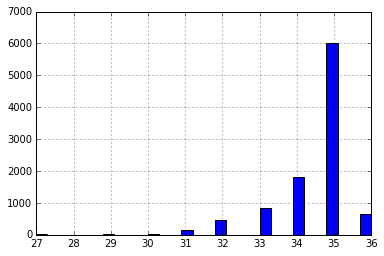

In [37]:
##########
# for P
##########
s = pd.Series(list(map(len, pool.samples)))
s.hist(bins=30)

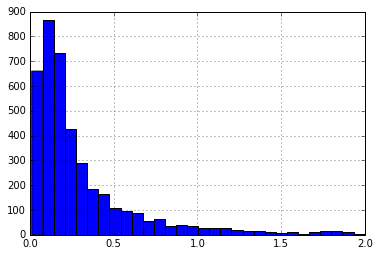

In [38]:
out_deg = g.degree_property_map('out', weight=p).a
pd.Series(out_deg[out_deg < 2]).hist(bins=30)

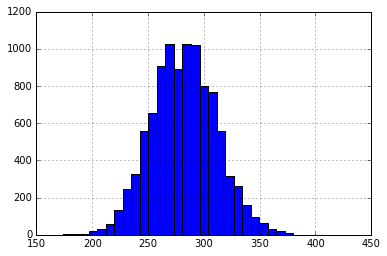

In [23]:
##########
# for **P prime***
##########
trees = [swap_end_points(random_steiner_tree(gi, X, root, method=sampling_method))
         for i in range(n_samples)]
s = pd.Series(list(map(len, trees)))
s.hist(bins=30)

In [24]:
from viz_helpers import tree_plot_setting, visualize


top_trees = Counter(pool.samples).most_common(3)


for t, f in top_trees:
    print('frequency/size', f, len(t))
    setting = tree_plot_setting(g, c, X, t)
    visualize(g, pos,
              **setting)

frequency/size 9203 198


NameError: name 'pos' is not defined

In [ ]:
estimator = TreeBasedStatistics(g, pool.samples)

probas = infection_probability(g, X, pool, estimator)

In [ ]:
from viz_helpers import InfectionProbabilityViz
viz = InfectionProbabilityViz(g_und, pos)
viz.plot(c, X, probas)


In [ ]:
pd.Series(list(map(len, pool.samples))).hist

In [ ]:
ans, trees, resampled_trees = one_run(g_rev, X, root, n_samples, sampling_method,
                                      return_samples=True)

In [ ]:
pd.Series(list(map(len, trees))).hist()

In [ ]:
len(infected_nodes(c))

In [ ]:
len(X)

In [ ]:
pd.Series(list(map(len, resampled_trees))).hist()

In [ ]:
ans